# Simple Salesforce marketing attribution with Python+Pandas

This is v3 my campaign attribution code. It uses Python+Pandas+Pandaforce to generate an Excel output of campaigns with all members as well as first touch and last touch statistics across the lead, contact, opportunity, and opportunity contact role objects, as well as a summary tab for of the three calculation modes. This is all possible without expensive custom architecture or 3rd party tools and can save a lot of time when done correctly.

Example campaign summary output:
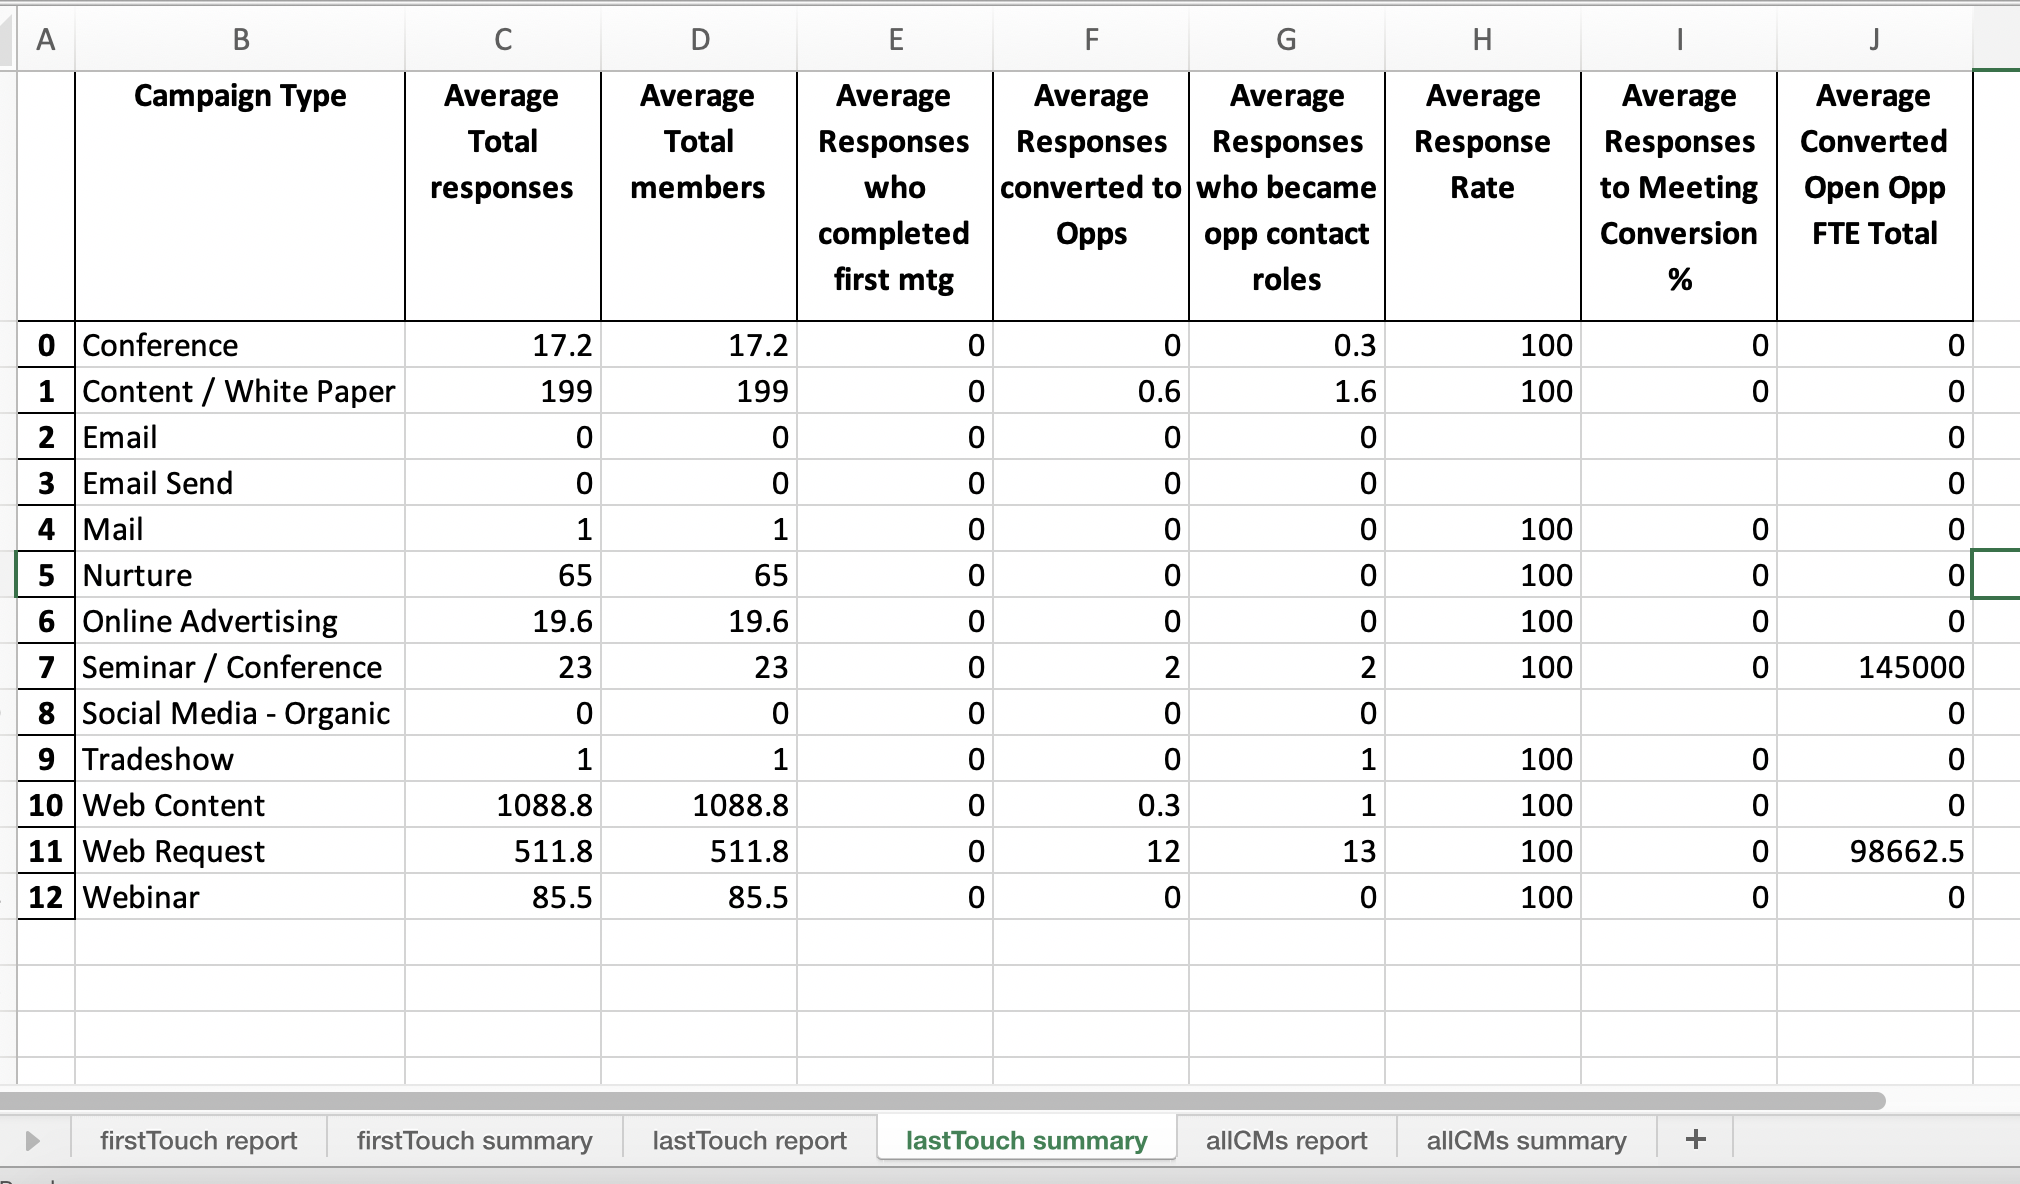


Example full campaign data output:
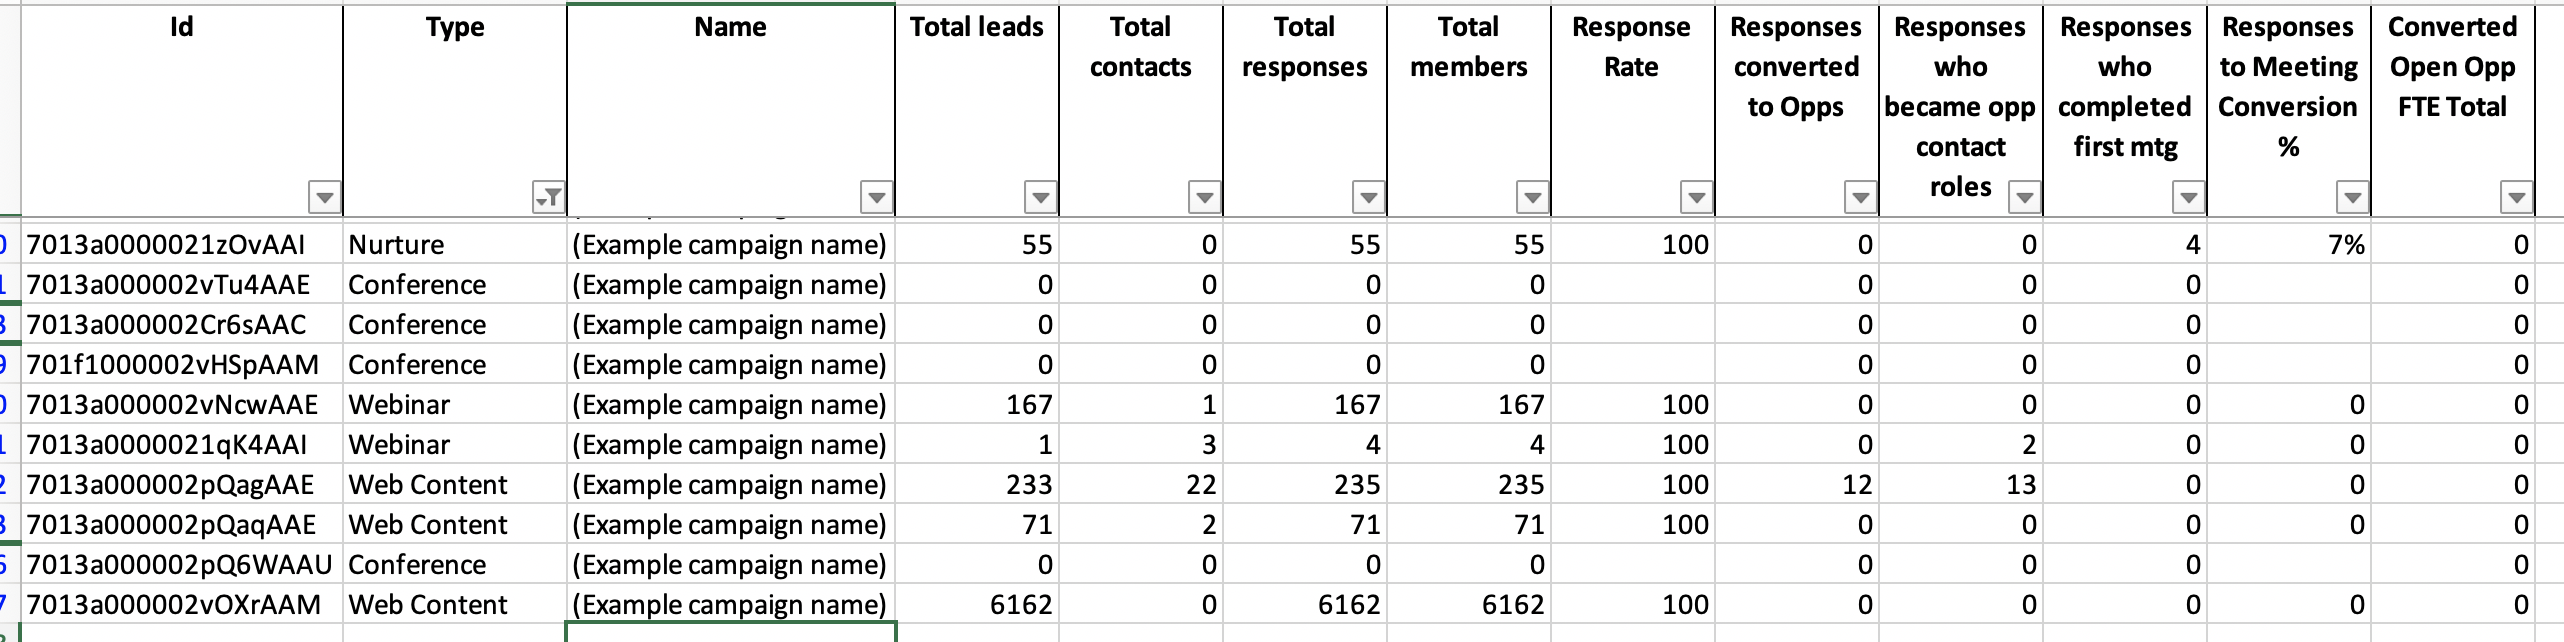

# Setting up the environment

These first few cells import all needed functions and logs us in using pandaforce, a package which lets us read Salesforce tables straight into Pandas dataframes.

In [1]:
from pandaforce import pandaforce as pf
import pandas as pd
import csv
import datetime
from xlsxwriter.utility import xl_rowcol_to_cell

In [ ]:
# get password
pw=input()

In [ ]:
# Get security token
st=input()

In [ ]:
sf=pf.login(username=YOUR_USERNAME_HERE, 
            password=pw, 
            orgid=YOUR_ORGID_HERE,
            securitytoken=st)

# Extracting data

Now, we begin to use Pandaforce  to query Salesforce using SOQL to extract our  data. 

We'll start with all campaigns that have anyone in them.

In [426]:
campdf=sf.getdf("SELECT id, type, name FROM campaign WHERE NumberOfLeads > 0 OR NumberOfContacts > 0 \
                    ORDER BY Name ASC")

In the same vein we query the DB for leads, campaigns, OCRs, and contacts. It may take some time to complete this one -- you may want to break it up into mulitple cells. There's various custom fields that are important to the specific client I worked with here, so you'll want to examine the query and generalize.

In [447]:
# Get all leads-- we include a custom field for the key 'first meeting completed' sales milestone
leadsdf=sf.getdf("SELECT id, ConvertedOpportunityId, First_Meeting_Completed__c, Status FROM lead \
                    WHERE IsDeleted=false")
# Get all contacts (again with 'first meeting completed')
contactdf=sf.getdf("SELECT id, First_Meeting_Completed__c FROM contact WHERE IsDeleted=false")
# Get all campaign members, including their response date which we'll use for first/last touch
cmdf=sf.getdf("SELECT id, leadid, contactid, leadorcontactid, CampaignId, HasResponded, \
                        FirstRespondedDate FROM campaignmember WHERE IsDeleted=false")
# Get all opp contact roles
ocrdf=sf.getdf("SELECT id,ContactId, OpportunityId from OpportunityContactRole WHERE IsDeleted=false")
# Get all opps including a custom FTE field
oppdf=sf.getdf("SELECT id, IsClosed, IsWon, FTE__c FROM Opportunity WHERE IsDeleted=false")

# Setting up our summary table and Excel output format

First, this code defines the function which creates the beginning of our summary table, which will start off blank and then we'll populate it. Note that there are a few custom KPIs here around first meetings and FTEs.

You'll probably want to read ahead and then come back to this. Essentially this will take a dataframe with our raw data of every single campaign + all its outputs, and summarize the stats based off the dataframe that is inputted to generate a summary of statistics grouped by Campaign Type.

In [457]:
def createSummaryTable(df):

    # Define the columns we want to summarize
    summaryStats=['Total responses',
                  'Total members',
                  'Responses who completed first mtg', 
                  'Responses converted to Opps',
                  'Responses who became opp contact roles',
                  'Response Rate',
                  'Responses to Meeting Conversion %',
                  'Converted Open Opp FTE Total']

    # Generate the summary dataframe, summarizing all of the 'summaryStats' columns' averages, grouped by Campaign Type
    summary=df.groupby(by="Type", as_index=False )[summaryStats].mean()\
        .add_prefix("Average ") # Add "average" to all columns
    summary=summary.rename(columns={"Average Type": "Campaign Type"}) #Clean up that first column to not say "Avg"
    summary.iloc[:,1:]=round(summary.iloc[:,1:],1) #round all summary stats to 1 digit

    # Reformat percent columns
    percentColumns=['Average Response Rate', #first define the % columns
                   'Average Responses to Meeting Conversion %']
    
    return summary

Next, let's create an output Excel filepath with a now() datetime stamp.
*Make sure to change to your own file path below!*

In [ ]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H%M")

# Make sure to put your own filepath here!
filePath=("/Users/martinbourqui/Downloads/Campaign report "+now+".xlsx")

# Generating input tables for our master function

The following code does the heavy lifting of calculating the remaining summary columns on a campaign-by-campaign
basis. This is necessary for summarizing any further.

This section is filtering dataframes so they're easier to reference and filter further when we loop through the campaigns one by one. Each one of these dataframes will feed one of our summary statistic columns defined in the `createSummaryTable` function above.

In [ ]:
# Get contact and lead ids that had first meeting completed for filtering
leadFirstMtgIds=leadsdf[leadsdf.First_Meeting_Completed__c==True]['Id']
contactFirstMtgIds=contactdf[contactdf.First_Meeting_Completed__c==True]['Id'] 

# Get series of leads converted to opps
leadConvertedOpps=leadsdf[leadsdf.ConvertedOpportunityId.notnull()]['Id'] 

Now we're going to start joining dataframes to the master campaign member dataframe queried near the beginning. ('cmdf' = campaign member dataframe.) First we're going to merge leads and opps into the campaign member dataframe.

In [ ]:
# Code to find campaign members who have converted opps' FTEs.
cmdf=cmdf.merge(leadsdf,how='left',left_on='LeadId',
                              right_on='Id',suffixes=(None,"_lead")) #add lead data to campaign response df
cmdf=cmdf.merge(oppdf,how='left',left_on='ConvertedOpportunityId',
                               right_on='Id',suffixes=(None,"_opp")) #next, add opp data to get that FTE number

Next, take all campaign members and sort by responded date, filter out anything without a responded date.
We're going to make a first touch and last touch dataframe here which will populate our 'first touch' and 'last  touch' summary tabs of our Excel output.
We'll dedupe df by `LeadOrContactId` (a handy auto-generated Salesforce summary field) to make it clear that we're only capturing one row person and not double-counting leads who convert to contacts.
We have to dedupe by that field only because a lead converted to contact may have diff leadId, ContactId fields.

In [ ]:
ftouchdf=cmdf[cmdf.FirstRespondedDate.notnull()]\
            .sort_values(by=['FirstRespondedDate'])\
            .drop_duplicates(subset=['LeadOrContactId'], keep='first') #drop duplicates, keep only first
ltouchdf=cmdf[cmdf.FirstRespondedDate.notnull()]\
            .sort_values(by=['FirstRespondedDate'])\
            .drop_duplicates(subset=['LeadOrContactId'], keep='last') #drop duplicates, keep only last

Now we're going to get contacts with opportunity contact roles merged into a dataframe, and then into a list, for joining into that `'Responses who became opp contact roles'` column we'll be generating.

In [ ]:
# Get all contacts with OCRs into merged df, then into a list
contactswOCRsdf=contactdf.merge \
    (ocrdf,how='right',left_on='Id',right_on='ContactId',suffixes=("_contact","ocr"))
contactswOCRs=contactswOCRsdf['Id_contact'].tolist()

Next, I created three 'calculation modes' that will feed our final looping functino to generate the three tabs (first touch, last touch, and all campaign membershps.) Each calc mode has a key-value pair which sets the input dataframe for the final function as one of the three campaign member dataframes. This dictionary will later hold the output dataframes as well.

In [ ]:
calcmodes={ 
        "firstTouch": {"inputDF":ftouchdf},
        "lastTouch": {"inputDF":ltouchdf},
        "allCMs": {"inputDF":cmdf}
    }

# The master output function

Finally, I define the function that will add the calculated value columns for list of campaigns. I got some feedback from an experienced Python dev that this function runs long, and I agree. Since I can't easily split this up in a notebook, I rely more on comments to annotate the code here.

In short, the function loops through each of the calculation modes and:
- sets which of the 3 campaign member dataframes we are working with
- filters down responses, contacts, and leads within each dataframe 
- loops through each campaign row within each table, calculating the statistic value in each cell.
- Reformats and reorders the outputs
- Generates a summary table for each of the output tables, so we will end up with six total tables/dataframes for output:
    - A 'first touch' table for each campaign + a summary table grouped by campaign type
    - A 'last touch' table for each campaign + a summary table grouped by campaign type
    - A 'all campaign members' table for each campaign + a summary table grouped by type
    
Last but not least, we run  the function,  which generates the Excel output with all six tabs.

In [459]:
def generateCalcCampaignValues(campaigndf):

    for calcmode in calcmodes:
        
        masterCMdf=calcmodes[calcmode]["inputDF"] # this sets which of the 3 CM DFs we are working with
        print("Generating "+calcmode+" dataframe...")
        keydf=campaigndf #this assigns the key dataframe name to the value of the campaign df the function is running with
        
        # Get the 3 campaign member DFs that will generate our all CM, first touch, last touch readouts
        cmResponses=masterCMdf[masterCMdf['HasResponded']==True] # Get just CM Responses
        leadCMs=masterCMdf[masterCMdf.LeadId.notnull()] # Get only CMs that are just leads
        contactCMs=masterCMdf[masterCMdf.ContactId.notnull()] # Get only CMs that are contacts
        
    
        # This for loop will go through each campaign ID and then count campaign members that meet criteria
        for i in enumerate(keydf['Id']): 
            loopcampid=i[1] # this is the campaign id to work on

            # Generate number of leads column
            loopLeads=leadCMs[leadCMs['CampaignId']==loopcampid] #Narrow to only leads in the loop campaign
            keydf.loc[keydf.Id==loopcampid,'Total leads']=len(loopLeads) # Count the total

            # Generate the number of contacts column
            loopContacts=contactCMs[contactCMs['CampaignId']==loopcampid] #Narrow to only leads in the loop campaign
            keydf.loc[keydf.Id==loopcampid,'Total contacts']=len(loopContacts) # Count the total

            #next, get just CM responses from that campaign, filtering down the pre-defined CM dataframe.
            #this will be used to calculate the next several columns
            loopCMResps=cmResponses[cmResponses['CampaignId']==loopcampid] 

            # Generate Total Responses column
            keydf.loc[keydf.Id==loopcampid,'Total responses']=len(loopCMResps)

            # Generate total members column by filtering from the full campaign member DB
            loopCMstotal=masterCMdf[masterCMdf['CampaignId']==loopcampid] 
            keydf.loc[keydf.Id==loopcampid,'Total members']=len(loopCMstotal)

            # These lines are for calculating opps converted
            loopOpps=loopCMResps[loopCMResps.ConvertedOpportunityId.notnull()]
            # now, count opps in new column
            keydf.loc[keydf.Id==loopcampid,'Responses converted to Opps']=len(loopOpps)

            # These lines are for calculating contacts with OCRs 
            loopOCRs=loopCMResps[loopCMResps.ContactId.isin(contactswOCRs)]
            #next, count OCRs in new col
            keydf.loc[keydf.Id==loopcampid,'Responses who became opp contact roles']=len(loopOCRs) 

            # These lines are for calculating first meetings within the campaign
            # first, filter lead first meeting within CMs
            loopFirstLeadMtgs=loopCMResps[loopCMResps.LeadOrContactId.isin(leadFirstMtgIds)] 
            # next, filter contact first meeting within CMs
            loopFirstContactMtgs=loopCMResps[loopCMResps.LeadOrContactId.isin(contactFirstMtgIds)] 
            keydf.loc[keydf.Id==loopcampid,'Responses who completed first mtg']= \
                (len(loopFirstLeadMtgs)+len(loopFirstContactMtgs)) #count first meeting in new column

            # Calculate total FTEs from our existing loopOpps df of opps converted from leads
            loopOpenOpps=loopCMResps[loopCMResps['IsClosed']==False]
            keydf.loc[keydf.Id==loopcampid,'Converted Open Opp FTE Total']=loopOpenOpps['FTE__c'].sum()


        # Reformat the relevant summary stats as integers so they don't display weird
        # First make a list of the relevant columns to change
        intstats=['Responses who completed first mtg', 'Responses converted to Opps','Responses who became opp contact roles']
        # Then change them
        keydf.loc[:,intstats] = keydf.loc[:,intstats].astype(int)

        # Generate  response rate column
        keydf['Response Rate']=round((100*(keydf['Total responses']/keydf['Total members'])),1)

        # Generate Response --> Meeting conversion rate
        keydf['Responses to Meeting Conversion %']= \
                        round((100*(keydf['Responses who completed first mtg']/keydf['Total responses'])),1)

        dfToWrite=keydf.copy()
        
        #  # # Reorganize the columns
        reorderedColumns=['Id',
                          'Type',
                          'Name',
                          'Total leads',
                           'Total contacts',
                           'Total responses',
                           'Total members',
                           'Response Rate',
                           'Responses converted to Opps',
                           'Responses who became opp contact roles',
                           'Responses who completed first mtg',
                           'Responses to Meeting Conversion %',
                         'Converted Open Opp FTE Total']
        dfToWrite=dfToWrite[reorderedColumns]
    
        # add the keydf to the dictionary
        calcmodes[calcmode].update({'outputDF': dfToWrite})
        
        # generate the summary table and add it to the dictionary as a new summaryTable entry
        calcmodes[calcmode].update({'summaryTable': createSummaryTable(calcmodes[calcmode]['outputDF'])})

    ''' Now write the output tables and their summaries to excel'''
    with pd.ExcelWriter(filePath) as writer:  
        for calcmode in calcmodes:
            outputSheetName=str(calcmode+" report")
            outputSummaryName=str(calcmode+" summary")
            calcmodes[calcmode]['outputDF'].to_excel(writer, sheet_name=outputSheetName)
            calcmodes[calcmode]['summaryTable'].to_excel(writer, sheet_name=outputSummaryName)        

# Finally, generate the campaign table additional values based on the existing campaign df 
generateCalcCampaignValues(campdf)

Generating firstTouch dataframe...
Generating lastTouch dataframe...
Generating allCMs dataframe...


...And that's it. Thanks for reading -- reach out with questions or feedback!

Future to-dos:
- Investigate and fix response rates being either 100% or blank
- Fix rounding to two or three digits for low response rates to be tracked
- Fix formatting on percentage columns --Xlsx writer has some documentation around this.  https://xlsxwriter.readthedocs.io/getting_started.html
- Add more formatting in general to output table for ease of reading